# Machine Learning Fundamentals - Lecture 06

In [7]:
# Import the required libraries using the commonly use short names
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization libraries
import matplotlib.pyplot as plt

# Machine Learning libraries and functions
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

## Load and clean the League of Legends dataset

In [ ]:
# Data-cleaning logic (dropna, duplicates, constant columns) was outlined using LLM assistance

# Load the dataset (note the use of the Path object)
df = pd.read_csv(Path("high_diamond_ranked_10min.csv"))

# Clean the dataset
df = df.dropna().drop_duplicates() # Remove missing values and duplicates

# Drop columns that are not useful for prediction
df = df.drop(columns=["gameId"], errors="ignore") # Drop 'gameId' if it exists
constant_cols = [c for c in df.columns if df[c].nunique() <= 1] # Identify constant columns
if constant_cols: 
    df = df.drop(columns=constant_cols) # Drop constant columns if any

## Mini Project 6: League of Legends Dataset

Best hyperparameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best mean F1-macro (k=5): 0.7356
Confusion matrix:
 [[712 278]
 [280 706]]
Accuracy: 0.7176
Precision: 0.7175
Recall: 0.7160
F1-score (macro): 0.7176
AUC: 0.8032


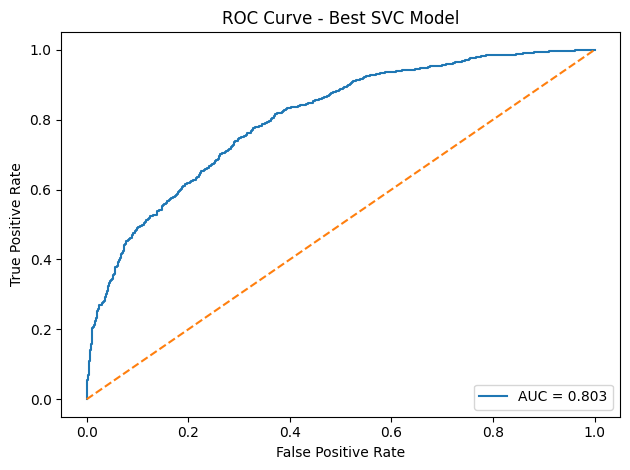

F1 per fold: [0.75   0.7432 0.7335 0.712  0.7391]
Mean ± SD: 0.7356 ± 0.0129


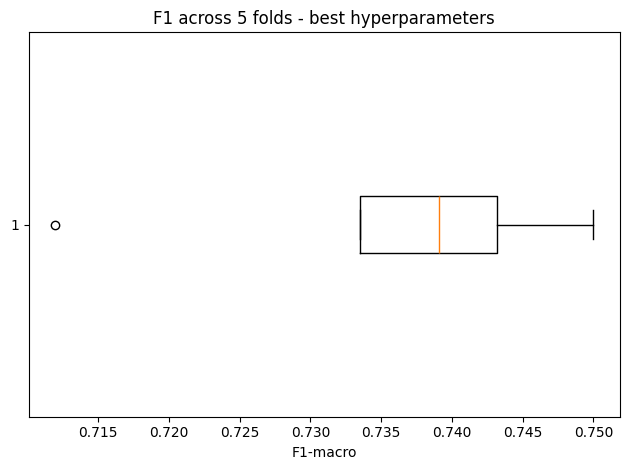

In [9]:
# -----------------------------------------------------
# Prepare data
# -----------------------------------------------------

X = df.drop(columns=["blueWins"])
y = df["blueWins"].astype(int)  # Ensure y is of integer type

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# -----------------------------------------------------
# Create and train a classifier using a pipeline
# -----------------------------------------------------

# Create a pipeline that first standardizes the data and then applies a SVC
clf = make_pipeline(StandardScaler(), SVC())


# -----------------------------------------------------
# k-Fold Cross-Validation with Grid Search
# -----------------------------------------------------

# Define the StratifiedKFold cross-validator
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = [
    # Linear
    {"svc__kernel": ["linear"],
     "svc__C": [0.00001, 0.001, 0.1, 1, 100, 10000],
     "svc__class_weight": [None, "balanced"]},

    # RBF
    {"svc__kernel": ["rbf"],
     "svc__C": [0.00001, 0.001, 0.1, 1, 100, 10000],
     "svc__gamma": ["scale", "auto", 0.001, 0.01, 0.1],
     "svc__class_weight": [None, "balanced"]},

    # Poly
    {"svc__kernel": ["poly"],
     "svc__C": [0.00001, 0.001, 0.1, 1, 100, 10000],
     "svc__degree": [2, 3, 4],
     "svc__gamma": ["scale", "auto", 0.01],
     "svc__class_weight": [None, "balanced"]},
]

# Create the GridSearchCV object
grid = GridSearchCV(clf, param_grid, cv=cv5, scoring='f1_macro', n_jobs=-1)
# Fit the model using grid search
grid.fit(X_train, y_train)


# -----------------------------------------------------
# Present the best hyperparameters found
# -----------------------------------------------------

# Print best hyperparameters and F1-macro mean from 5-fold k-Fold CV
print("Best hyperparameters:", grid.best_params_)
print(f"Best mean F1-macro (k=5): {grid.best_score_:.4f}")

# Retrieve the best model found by GridSearchCV
best_model = grid.best_estimator_


# -----------------------------------------------------
# Evaluate on the test set
# -----------------------------------------------------

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Compute all required classification metrics
cm   = confusion_matrix(y_test, y_pred)
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1m  = f1_score(y_test, y_pred, average="macro")

# Display results
print("Confusion matrix:\n", cm)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score (macro): {f1m:.4f}")


# -----------------------------------------------------
# ROC curve and AUC
# -----------------------------------------------------

# Use decision_function to get the scores for ROC curve
y_score = best_model.decision_function(X_test)
auc = roc_auc_score(y_test, y_score)
fpr, tpr, _ = roc_curve(y_test, y_score)

print(f"AUC: {auc:.4f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best SVC Model")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# -----------------------------------------------------
# F1-score distribution across folds
# -----------------------------------------------------

# Cross-validate the best model on the training set
f1_per_fold = cross_val_score(
    best_model, X_train, y_train, scoring="f1_macro", cv=cv5, n_jobs=-1
)

# Print the F1 scores per fold (array) and the mean ± std
print("F1 per fold:", np.round(f1_per_fold, 4))
print(f"Mean ± SD: {f1_per_fold.mean():.4f} ± {f1_per_fold.std():.4f}")

# Boxplot of the fold distribution
plt.figure()
plt.boxplot(f1_per_fold, vert=False)
plt.xlabel("F1-macro")
plt.title("F1 across 5 folds - best hyperparameters")
plt.tight_layout()
plt.show()

### Intuition and Interpretation

#### Why these particular hyperparameter values behaved well with this dataset and algorithm

The best parameters found were `kernel = 'rbf'`, `C = 0.1`, `gamma = 0.01`, and `class_weight = 'balanced'`.

This means that a **Support Vector Classifier** using the **RBF kernel** performed best for this dataset. The RBF kernel can capture non-linear relationships between the match statistics and the outcome (`blueWins`). In *League of Legends*, a win is rarely caused by a single variable, it usually depends on the **interaction** between several features like gold difference, towers, kills, and objectives. A linear model cannot capture these curved patterns, while the RBF kernel can form a flexible boundary that adjusts to them without explicitly adding polynomial features.

The value **`C = 0.1`** represents **moderate regularization**. The `C` parameter controls the balance between achieving a wide margin and correctly classifying all training points.  
- If `C` is too small, the model becomes too tolerant of misclassifications and may underfit.  
- If `C` is too large, it overfits, focusing too much on individual samples.  
Here, `C = 0.1` allows the model to maintain a smooth boundary that generalizes well across matches, not just fitting the training data.

The value **`gamma = 0.01`** controls how far the influence of each support vector reaches. A small `gamma` makes the decision boundary smoother and more global, while a large value makes it very sensitive to local variations or noise.  
At `gamma = 0.01`, the classifier finds a good middle ground: it captures the main structure of the data while avoiding the “spiky” decision surfaces typical of high gamma values. This is consistent with the relatively stable F1 scores across folds.

The **balanced class weight** setting compensates for small differences in the number of wins and losses. It ensures that both outcomes contribute equally to the optimization process, which helps maximize the **F1-macro score** instead of just the overall accuracy.

The **cross-validation scores** `[0.7500, 0.7432, 0.7335, 0.7120, 0.7391]` show that the model behaves consistently across folds, with only minor variation. The single lower score (`0.7120`) likely corresponds to a data split where a few atypical matches, perhaps very short games or ones with unusual early-game statistics, made the boundary less effective. That same pattern explains the **single outlier** visible in the boxplot: it represents the one fold where the model performed slightly below the others, possibly due to a random concentration of less representative examples. Even then, the performance drop is small, confirming the model’s robustness.

The **confusion matrix**
```
[[712 278]
[280 706]]
```
shows a balanced number of correct predictions between the two outcomes. Both classes have similar precision and recall, which supports that the model is not biased toward either predicting wins or losses. It generalizes well and maintains steady predictive power across both categories.

---

#### The meaning of the AUC plot

The **ROC curve** illustrates how the classifier performs across all possible decision thresholds by plotting the **True Positive Rate** against the **False Positive Rate**.  
The **AUC (Area Under the Curve)** summarizes this information in one number, indicating how well the model separates the two classes overall.

Here, the **AUC = 0.8032**, meaning there is about an **80.3% chance** that the model will assign a higher confidence score to a randomly chosen winning match than to a losing one. The ROC curve lies clearly above the diagonal reference line, which represents random guessing, showing that the model reliably distinguishes between wins and losses at multiple thresholds.

In practice, this means the classifier is not just performing well at one specific cutoff (like 0.5) but maintains strong discrimination ability across a range of thresholds. Combined with the balanced confusion matrix and stable F1 values, the AUC confirms that the RBF SVC captures meaningful, non-linear structures in the data and generalizes effectively to unseen matches.

---

#### Reflection and hyperparameter interpretation

Looking at these results, the combination of **moderate regularization (C=0.1)** and **smooth non-linearity (gamma=0.01)** seems to match the nature of this problem perfectly. The model avoids both extremes: it doesn’t overfit to individual data points, and it doesn’t oversimplify the complex relationships between the in-game metrics. The decision boundary it learns reflects how multiple small advantages together lead to a win, rather than one isolated feature determining the outcome.

The slight outlier in the cross-validation plot is a reminder that real-world data always includes some variation. Even in a balanced and well-trained model, performance can fluctuate a bit depending on how the data is split. In this case, the variation is small, showing that the model remains stable and trustworthy.

---

#### Summary of what each hyperparameter does

- **`kernel`**: Determines the type of boundary.  
  - `'linear'` -> straight line (simple relationships).  
  - `'rbf'` -> curved surface (captures non-linear relationships).  
  - `'poly'` -> polynomial boundary (controlled by degree).  

- **`C`**: Controls regularization.  
  - Low values -> simpler model, larger margin, higher bias.  
  - High values -> more complex model, smaller margin, higher variance.  

- **`gamma`** (for RBF and poly): Defines how far each support vector’s influence extends.  
  - Low gamma -> smooth global boundary.  
  - High gamma -> very local, risk of overfitting.  

- **`class_weight`**: Adjusts the importance of each class in training. `'balanced'` ensures both outcomes contribute equally.  

- **`StandardScaler()`**: Standardizes feature scales so all variables contribute fairly to distance calculations.  

- **`StratifiedKFold`**: Preserves the win/loss ratio across folds, ensuring consistent and fair cross-validation.  

Together, these choices produced a model that balances simplicity, generalization, and flexibility, an RBF SVC that fits the structure of the data well, with strong overall discrimination (AUC = 0.8032) and stable F1 performance across folds.